In [43]:
from collections import Counter, defaultdict
import itertools
import matplotlib.pyplot as plt
from typing import List


In [44]:
class PlateFillError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)

class PlateFiller:
    def __init__(self, plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int):
        self.plate_size = plate_size
        self.samples = samples
        self.reagents = reagents
        self.replicas = replicas
        self.well_num = well_num
        self.check_if_enough_plates()
        self.colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta']
        self.color_cycle = itertools.cycle(self.colors)
        self.color_map = {}

    def check_if_enough_plates(self):
        wells_available = self.plate_size * self.well_num
        wells_needed = 0
        experiment_count = len(self.replicas)
        for experiment_number in range(experiment_count):
            wells_needed += len(self.samples[experiment_number]) * len(self.reagents[experiment_number]) * self.replicas[experiment_number]
        
        if wells_needed > wells_available:
            error_message = f"Number of wells needed {wells_needed} exceed available number of wells {wells_available}."
            raise PlateFillError(error_message)
    
    def evaluate_microplate(self, plates: List[List[List[str]]]) -> int:
        penalty = 0
        for plate in plates:
            previous_sample, previous_reagent = plate[0][0]
            for row in plate:
                for well in row:
                    if any(well):
                        current_sample, current_reagent = well
                        if current_sample != previous_sample:
                            penalty += 1
                            previous_sample = current_sample
                        if current_reagent != previous_reagent:
                            penalty += 1
                            previous_reagent = current_reagent
        return penalty
    
    def create_empty_plate(self, rows: int, cols:int ) -> List[List[int]]:
        return [[[None] for _ in range(cols)] for _ in range(rows)]

    def fill_plate(self, plate, items, rows, cols):
        current_well = 0
        plates = []
        for sample, reagent in items:
            if current_well == self.plate_size:
                plates.append(plate)
                plate = self.create_empty_plate(rows, cols)
                current_well = 0

            row_index = current_well // cols
            col_index = current_well % cols

            plate[row_index][col_index] = [sample, reagent]

            current_well += 1

        if plate:
            plates.append(plate)

        return plates
    
    def get_plate_dimensions(self):
        if self.plate_size == 96:
            num_rows = 8
            num_cols = 12
        elif self.plate_size == 384:
            num_rows = 16
            num_cols = 24
        return num_rows, num_cols


    def group_related_experiments(self):
        num_rows, num_cols = self.get_plate_dimensions()
        samples_per_reagent_counter = defaultdict(Counter)
        reagents_per_sample_counter = defaultdict(Counter)
        reagent_counter = Counter()
        sample_counter = Counter()

        for exp_samples, exp_reagents, exp_replicas in zip(self.samples, self.reagents, self.replicas):
            for reagent in exp_reagents:
                for sample in exp_samples:
                    samples_per_reagent_counter[reagent][sample] += exp_replicas
                    reagents_per_sample_counter[sample][reagent] += exp_replicas
                    sample_counter[sample] += exp_replicas
                    reagent_counter[reagent] += exp_replicas

        reagents_sorted_by_frequency = [key for key, _ in reagent_counter.most_common()]
        plate = self.create_empty_plate(num_rows, num_cols)

        items_by_reagent = []
        for reagent in reagents_sorted_by_frequency:
            for sample, freq in sorted(samples_per_reagent_counter[reagent].most_common()):
                for _ in range(freq):
                    items_by_reagent.append([sample, reagent])
        group_by_reagent_result = self.fill_plate(plate, items_by_reagent, num_rows, num_cols)

        plate = self.create_empty_plate(num_rows, num_cols)
        items_by_sample = []
        for sample in sample_counter:
            for reagent, freq in sorted(reagents_per_sample_counter[sample].most_common()):
                for _ in range(freq):
                    items_by_sample.append([sample, reagent])    
        group_by_sample_result = self.fill_plate(plate, items_by_sample, num_rows, num_cols)

        return group_by_reagent_result if self.evaluate_microplate(group_by_sample_result) >= self.evaluate_microplate(group_by_reagent_result) else group_by_sample_result

    def plot_plate(self, plate: List[List[List[str]]], color_by: str, plate_index: int) -> None:     
        number_of_rows, number_of_columns = self.get_plate_dimensions()
        figsize = (number_of_rows, number_of_columns)
        
        _, ax = plt.subplots(figsize=figsize)
        
        title_text = f"Colored by {color_by.capitalize()}"
        if plate_index is not None:
            title_text += f" | Plate Index: {plate_index}"
        plt.title(title_text)
        
        for i, row in enumerate(plate):
            for j, well in enumerate(row):
                if all(w is not None for w in well):
                    item_to_color = well[0] if color_by == 'sample' else well[1]
                    
                    if item_to_color not in self.color_map:
                        self.color_map[item_to_color] = next(self.color_cycle)
                    
                    ax.text(j, i, f"{well[0]}\n{well[1]}", ha='center', va='center', fontsize=8, color='black')
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor=self.color_map[item_to_color], edgecolor='black', linewidth=2))
                else:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='white', edgecolor='black', linewidth=2))
        
        row_labels = [chr(i) for i in range(ord('A'), ord('A') + number_of_rows)]
        col_labels = [i + 1 for i in range(number_of_columns)]

        for i, label in enumerate(row_labels):
            ax.text(-1, i, label, ha='center', va='center', fontsize=12, color='black')

        for j, label in enumerate(col_labels):
            ax.text(j, -1, str(label), ha='center', va='center', fontsize=12, color='black')

        ax.set_xlim(-0.5, len(plate[0])-0.5)
        ax.set_ylim(-0.5, len(plate)-0.5)
        ax.set_aspect('equal', 'box')
        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.show()

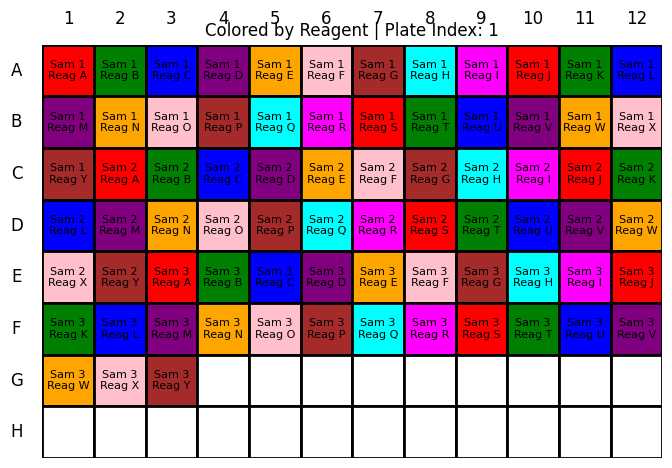

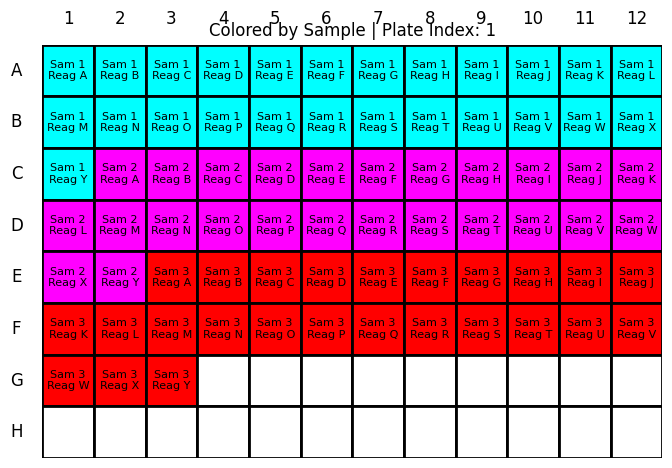

In [46]:
plate_size = 96
samples = [['Sam 1', 'Sam 2', 'Sam 3']]
reagents = [['Reag ' + chr(ord('A') + i) for i in range(25)]]
replicas = [1]
well_num = 3

try:
    plate_filler = PlateFiller(plate_size=plate_size, samples=samples, reagents=reagents, replicas=replicas, well_num=well_num)
    plates = plate_filler.group_related_experiments()
    for i, plate in enumerate(plates, 1):
        plate_filler.plot_plate(plate=plate, color_by='reagent', plate_index=i)
        if i == 5: break
    for i, plate in enumerate(plates, 1):
        plate_filler.plot_plate(plate=plate, color_by='sample', plate_index=i)
        if i == 5: break
except PlateFillError as e:
    raise